# Agreed Parameters
c (rate of infection) = 0.2 for all

gamma (rate of recovery) = 0.1 for all

beta_bb = 0.6

beta_ww = 0.1

beta_bw = 0.3

beta_wb = 0.2

death = [0.005] for all

death = [0.005, 0.007, 0.01] (White, Blue, Stay at Home) makes it more interesting

In [2]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [3]:
def sir_system_implicit(vars, S_prev, I_prev, R_prev, D_prev, beta, gamma, death, mu, c, dt):
    S_new, I_new, R_new, D_new = vars[0:3], vars[3:6], vars[6:9], vars[9:12]
    S_prev, I_prev, R_prev, D_prev = np.array(S_prev), np.array(I_prev), np.array(R_prev), np.array(D_prev)
    F = np.zeros(12)
    F[0:3] = S_new - S_prev + dt * (beta @ I_new * S_new * c - mu * R_new)
    F[3:6] = I_new - I_prev - dt * (beta @ I_new * S_new * c - gamma * I_new - death * I_new)
    F[6:9] = R_new - R_prev - dt * (gamma * I_new - mu * R_new)
    F[9:12] = D_new - D_prev - dt * death * I_new
    return F

In [4]:
def sir_model_implicit_euler_matrix(S0, I0, R0, D0, beta, gamma, dt, death, mu, T, c):
    # Initial conditions
    S = np.array(S0)
    I = np.array(I0)
    R = np.array(R0)
    D = np.array(D0)


    num_steps = int(T / dt)

    # Lists to store results
    S_list = [S]
    I_list = [I]
    R_list = [R]
    D_list = [D]
    for i in range(num_steps):
        S_prev = S
        I_prev = I
        R_prev = R
        D_prev = D

        # Solve the implicit Euler equations; this function is literally a black box to me I just found
        # someone else who implemented it on stack overflow and did what they did
        sol = opt.root(sir_system_implicit, np.concatenate((S, I, R, D)), args=(S_prev, I_prev, R_prev, D_prev, beta, gamma, death, mu, c, dt))
        sol = sol.x

        # Update state variables
        S, I, R, D = sol[0:3], sol[3:6], sol[6:9], sol[9:12]
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
        D_list.append(D)

    S_list = np.array(S_list)
    I_list = np.array(I_list)
    R_list = np.array(R_list)
    D_list = np.array(D_list)
    return S_list, I_list, R_list, D_list

In [5]:
S0 = [0.99, 0.99, 0.99]  # Initial susceptible population [white collar, blue collar, Stay at home]
I0 = [0.01, 0.01, 0.01]  # Initial infected population [white collar, blue collar, Stay at home]
R0 = [0.0, 0.0, 0.0]    # Initial recovered population [white collar, blue collar, Stay at home]
D0 = [0.0, 0.0, 0.0]    # Initial dead population [white collar, blue collar, Stay at home]

# Beta matrix with interaction rates, assuming interaction always causes infection, 
# Chance of an interaction with an infected person/day
beta = np.array([[0.25, 0.3, 0.13],  # beta_ww, beta_wb, beta_wo
                 [0.5, 0.95, 0.15], # beta_bw, beta_bb, beta_bo
                 [0.14, 0.14, 0.07]])  # beta_ow, beta_ob, beta_oo

# Infection Rate
# Chance of an interaction per beta
c = 0.6

# Chance of recovery per day of being infected
gamma = np.array([0.15, 0.1, 0.03])  # Recovery rates [gamma_w, gamma_b, gamma_o]

# Death Rates
# Chance of death per day of being infected
death = np.array([0.005, 0.005, 0.005]) # White collar, Blue Collar, Stay at Home

# Rates of immunity loss
# Chance of becoming susceptible per day of being recovered
mu = np.array([0.001, 0.001, 0.0014]) # White collar, Blue Collar, Stay at Home


dt = 0.01  # Time step
T = 100  # Total time

S_list, I_list, R_list, D_list = sir_model_implicit_euler_matrix(S0, I0, R0, D0, beta, gamma, dt, death, mu, T, c)

time = np.arange(0, T + dt, dt)

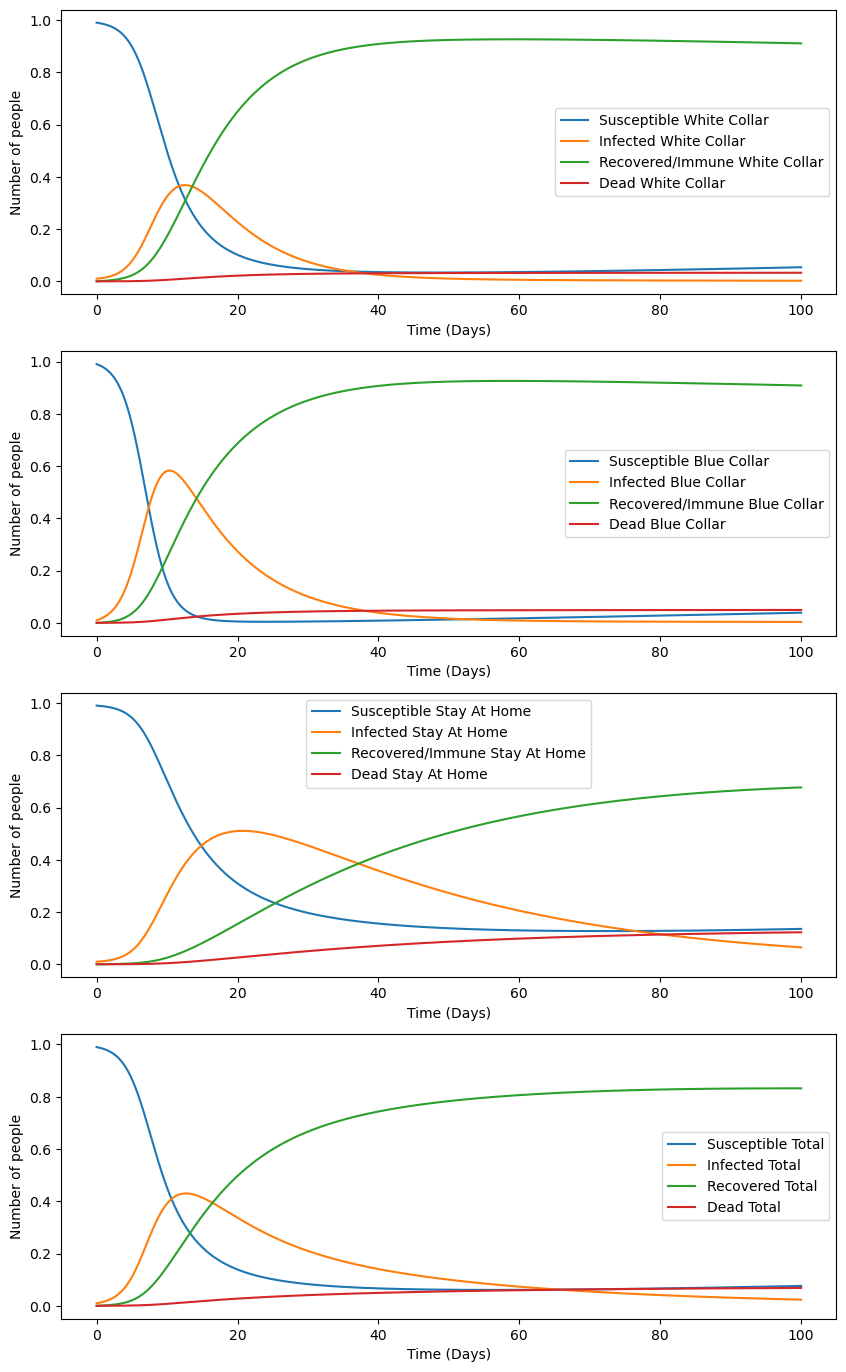

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(10, 17))

ax[0].plot(time, S_list[:, 0], label='Susceptible White Collar')
ax[0].plot(time, I_list[:, 0], label='Infected White Collar')
ax[0].plot(time, R_list[:, 0], label='Recovered/Immune White Collar')
ax[0].plot(time, D_list[:, 0], label='Dead White Collar')
ax[1].plot(time, S_list[:, 1], label='Susceptible Blue Collar')
ax[1].plot(time, I_list[:, 1], label='Infected Blue Collar')
ax[1].plot(time, R_list[:, 1], label='Recovered/Immune Blue Collar')
ax[1].plot(time, D_list[:, 1], label='Dead Blue Collar')
ax[2].plot(time, S_list[:, 2], label='Susceptible Stay At Home')
ax[2].plot(time, I_list[:, 2], label='Infected Stay At Home')
ax[2].plot(time, R_list[:, 2], label='Recovered/Immune Stay At Home')
ax[2].plot(time, D_list[:, 2], label='Dead Stay At Home')
ax[3].plot(time, np.sum(S_list[:,], 1)/3, label='Susceptible Total')
ax[3].plot(time, np.sum(I_list[:,], 1)/3, label='Infected Total')
ax[3].plot(time, np.sum(R_list[:,], 1)/3, label='Recovered Total')
ax[3].plot(time, np.sum(D_list[:,], 1)/3, label='Dead Total')

for i in range(4):
    ax[i].set_xlabel('Time (Days)')
    ax[i].set_ylabel('Number of people')
    ax[i].legend()

plt.show()

In [8]:
print("End: ")
print(f'White Collar: \n Susceptible: {S_list[:,0][-1]} \n Infected: {I_list[:,0][-1]} \n Recovered: {R_list[:,0][-1]} \n Dead: {D_list[:,0][-1]}')
print(f'Blue Collar: \n Susceptible: {S_list[:,1][-1]} \n Infected: {I_list[:,1][-1]} \n Recovered: {R_list[:,1][-1]} \n Dead: {D_list[:,1][-1]}')
print(f'Stay at Home: \n Susceptible: {S_list[:,2][-1]} \n Infected: {I_list[:,2][-1]} \n Recovered: {R_list[:,2][-1]} \n Dead: {D_list[:,2][-1]}')
print(f'Total: \n Suceptible: {np.sum(S_list[-1])/3} \n Infected: {np.sum(I_list[-1])/3} \n Recovered: {np.sum(R_list[-1])/3} \n Dead: {np.sum(D_list[-1])/3}')

print("")
print(f'Max infected:  \n White Collar: {np.max(I_list[:,0])} \n Blue Collar: {np.max(I_list[:,1])} \n Stay at Home: {np.max(I_list[:,2])} \n Total: {np.max(I_list[:,0] + I_list[:,1] + I_list[:,2])/3}') 

End: 
White Collar: 
 Susceptible: 0.05401457752186806 
 Infected: 0.0023337050854227034 
 Recovered: 0.91074308414709 
 Dead: 0.03290863324562218
Blue Collar: 
 Susceptible: 0.038787160687012136 
 Infected: 0.0034404369586638803 
 Recovered: 0.9084738309617653 
 Dead: 0.04929857139255712
Stay at Home: 
 Susceptible: 0.13547040427433782 
 Infected: 0.06485277230456131 
 Recovered: 0.6769955964313294 
 Dead: 0.12268122698977008
Total: 
 Suceptible: 0.07609071416107267 
 Infected: 0.02354230478288263 
 Recovered: 0.8320708371800616 
 Dead: 0.06829614387598312

Max infected:  
 White Collar: 0.3684338314197053 
 Blue Collar: 0.5828267720343767 
 Stay at Home: 0.5107529152518834 
 Total: 0.430050708055469
